# Instruction 
## Release Notes
First release of the the MLP_Fuelmap_SingleMap 2/14/2023 by wto@csustan.edu

### To train and predict the ML 
1. Load the Libraries from Fuelmap.ipynb first using %run Fuelmap.ipynb
2. Run the Train and Predict block. It will train the MLP with all of the non-zero tag data. Create the confusion matrix and print out the accuracies.

### To predict the fuelmap without training
1. Load the Libraries from Fuelmap.ipynb first using %run Fuelmap.ipynb
2. Run the Prediction Only Cell. This will run the prediction with the previously trained mlp. Create the confusion matrix and print out the accuracies.


In [1]:
# Load Libraries
%run Fuelmap.ipynb
## Defining cut parameters
RMSD_CUT = 12 #15.472021

Loaded LoadTrainingData()
Loaded Load2TrainingData()
Loaded RMS_of_band5x5()
Loaded PrintAcc()
Loaded SavePredictTif()


Xall_flat (4, 0)
X_matrix Shape (4, 7116, 5766)
X_flat Shape (4, 41030856)
Xall_flat (4, 41030856)
X_matrix Shape (4, 7116, 5772)
X_flat Shape (4, 41073552)
Xall_flat (4, 82104408)
X_matrix Shape (4, 7116, 5754)
X_flat Shape (4, 40945464)
Xall_flat (4, 123049872)
X_matrix Shape (4, 7116, 5778)
X_flat Shape (4, 41116248)
Xall_flat (4, 164166120)
X_matrix Shape (4, 7116, 5760)
X_flat Shape (4, 40988160)
Xall_flat (4, 205154280)
X_matrix Shape (4, 7122, 5778)
X_flat Shape (4, 41150916)
Xall_flat (4, 246305196)
X_matrix Shape (4, 7110, 5754)
X_flat Shape (4, 40910940)
Xall_flat (4, 287216136)
Xall_flat (287216136, 4)
Y_flat Shape (41030856,)
Yall_flat (41030856,)
Y_flat Shape (41073552,)
Yall_flat (82104408,)
Y_flat Shape (40945464,)
Yall_flat (123049872,)
Y_flat Shape (41116248,)
Yall_flat (164166120,)
Y_flat Shape (40988160,)
Yall_flat (205154280,)
Y_flat Shape (41150916,)
Yall_flat (246305196,)
Y_flat Shape (40910940,)
Yall_flat (287216136,)
Running mlp.fit
Test Split Score:  0.89779851

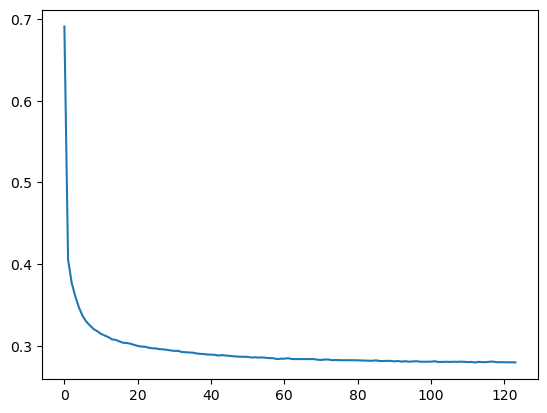

Running mlp.predict
Creating the Confusion Matrix


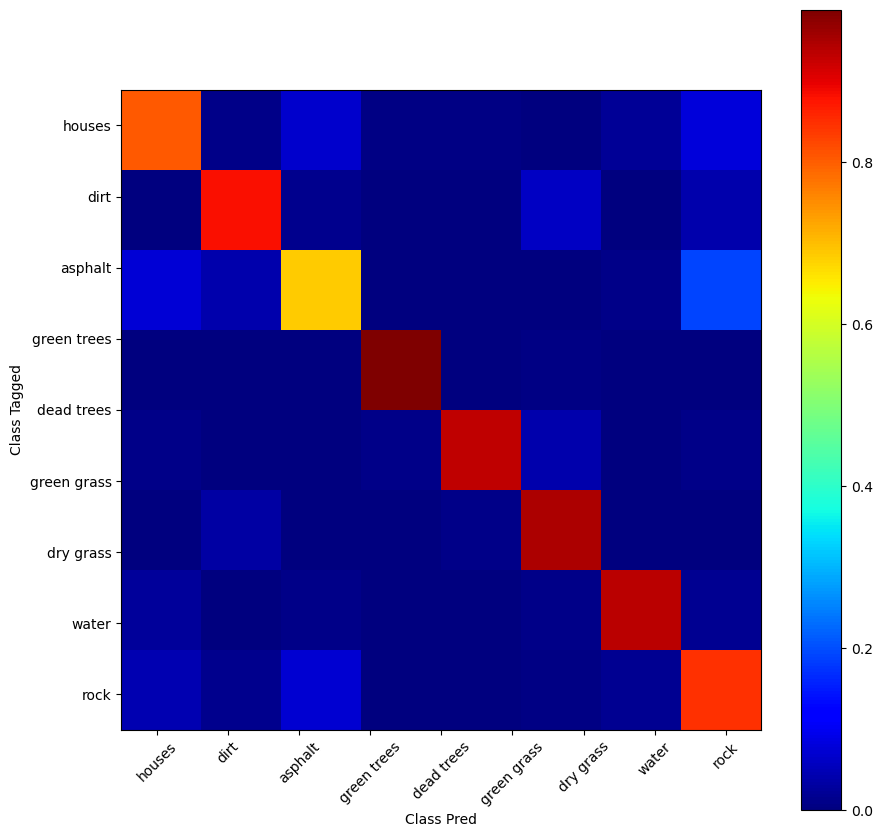

In [2]:
################### Training and Predict #########################################################
################### This block runs the Training (mlp.fit) then predict the classes for the entire map (mlp.predict)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
### Define your Input and Output Files
ImgFileList= [  '/data/wto/AerialImages/hxip_m_3711954_se_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711954_sw_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711955_nw_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711962_nw_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711954_ne_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711962_sw_11_100.tif',
                '/data/wto/AerialImages/hxip_m_3711955_ne_11_100.tif']
TagFileList=['hxip_m_3711954_se_11_100_agtag_nov27.tif',
             'hxip_m_3711954_sw_11_100_agfeb11.tif',
             'hxip_m_3711955_nw_11_100_agfeb11.tif',
             'hxip_m_3711962_nw_11_100_AK_2023Oct18.tif',
             'hxip_m_3711954_ne_11_100_AK_2023Oct18.tif',
             'hxip_m_3711962_sw_11_100_AK_2023Oct18.tif',
             'hxip_m_3711955_ne_11_100_AK_2023Oct18.tif']    

Xall_flat = np.empty([4,0])
print("Xall_flat", Xall_flat.shape)
#Loop through all the Image files to combine them together.
for ImgFile in ImgFileList:
    #Open the file and put the data into a 3D, 4 by N-xpixel by N-ypixel
    X_matrix = rio.open(ImgFile).read()
    #First flatten the matrix into 2D array of shape 4xNPixels
    X_flat = np.array([X_matrix[0].flatten(),
                    X_matrix[1].flatten(),
                    X_matrix[2].flatten(),
                    X_matrix[3].flatten()])
    Xall_flat = np.concatenate((Xall_flat,X_flat),axis = 1) 
    print("X_matrix Shape", X_matrix.shape)
    print("X_flat Shape", X_flat.shape)
    print("Xall_flat", Xall_flat.shape)

Xall_flat = Xall_flat.T
print("Xall_flat", Xall_flat.shape)
scaler = StandardScaler()
Xall_flat = scaler.fit_transform(Xall_flat)
    
Yall_flat = []
#Loop through all the Image files to combine them together.
for TagFile in TagFileList:
    #Open the file and put the data into a 3D, 4 by N-xpixel by N-ypixel
    Y_flat = rio.open(TagFile).read().astype(int).flatten()
    Yall_flat = np.concatenate((Yall_flat,Y_flat)) 
    print("Y_flat Shape", Y_flat.shape)
    print("Yall_flat", Yall_flat.shape)
Yall_flat[Yall_flat==6]=4

X_train, X_test, Y_train, Y_test = train_test_split(Xall_flat[Yall_flat!=0], Yall_flat[Yall_flat!=0], 
                                                        stratify = Yall_flat[Yall_flat!=0], 
                                                        random_state = 42,test_size= 0.1)

mlp = MLPClassifier(solver = 'sgd', learning_rate_init= 0.01, activation = 'relu', 
                    random_state = True, hidden_layer_sizes = [15,15,15,15])


print("Running mlp.fit")
mlp.fit(X_train,Y_train)
plt.plot(mlp.loss_curve_)
print("Test Split Score: ",mlp.score(X_test, Y_test))
plt.show()

#######################################
print("Running mlp.predict")
Y_predict = mlp.predict(Xall_flat)
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Yall_flat[Yall_flat!=0],Y_predict[Yall_flat!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

loading the data
houses tagged  711
roads tagged  436
asphalts tagged  1129
greentree tagged  2089
dead trees tagged  361
green grass tagged  3243
dry grass tagged  2810
water tagged  9191
rocks tagged  7463
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


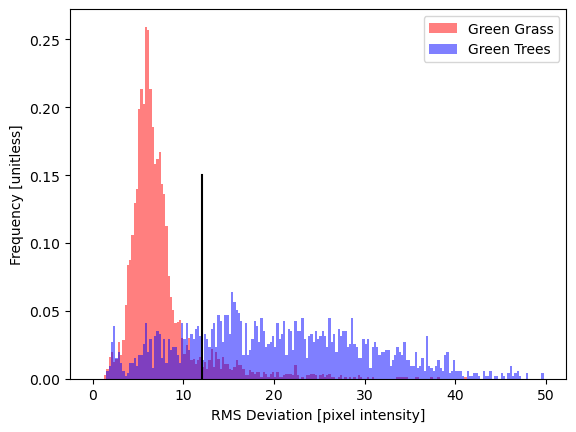

Creating the Confusion Matrix


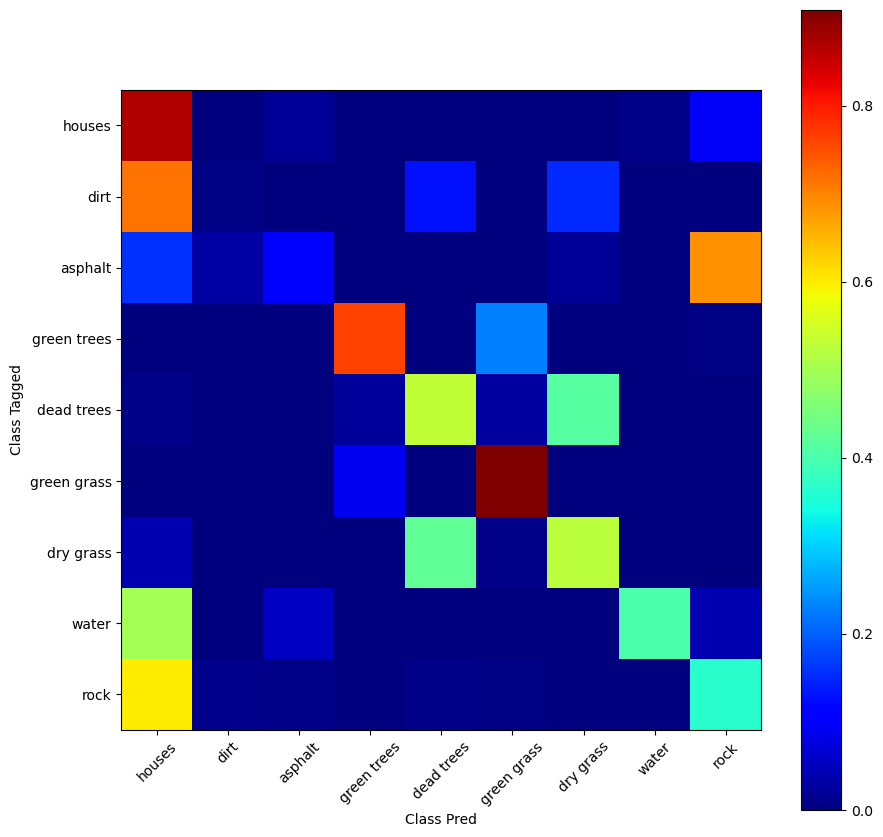

House Accuracy : 0.869198312236287
Dirt Accuracy : 0.0045871559633027525
Asphalt Accuracy : 0.10008857395925598
GreenTree Accuracy : 0.7630445189085687
DeadTree Accuracy : 0.5290858725761773
GreenGrass Accuracy : 0.9087264878199198
DryGrass Accuracy : 0.5249110320284698
Water Accuracy : 0.4043085627244043
Rock Accuracy : 0.3628567600160793
Overall Accuracy 0.4871505121568913
Unburnable Accuracy 0.9858425779186476
Mix Burnable Accuracy 0.9831824062095731
Unmixed Burnable Accuracy 0.7299776549453134
Saving as tif raster file
this took  580.6899688243866 seconds


In [3]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711954_se_11_100.tif'
tagFile2='hxip_m_3711954_se_11_100_agtag_nov27.tif'
outFile2="hxip_m_3711954_se_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  1418
roads tagged  3403
asphalts tagged  2964
greentree tagged  17906
dead trees tagged  8112
green grass tagged  4513
dry grass tagged  9572
water tagged  2549
rocks tagged  6568
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


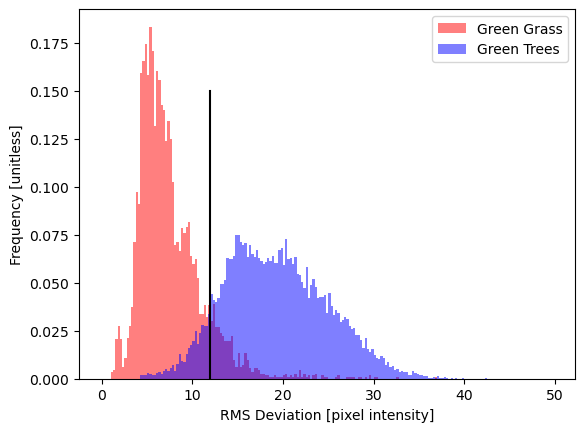

Creating the Confusion Matrix


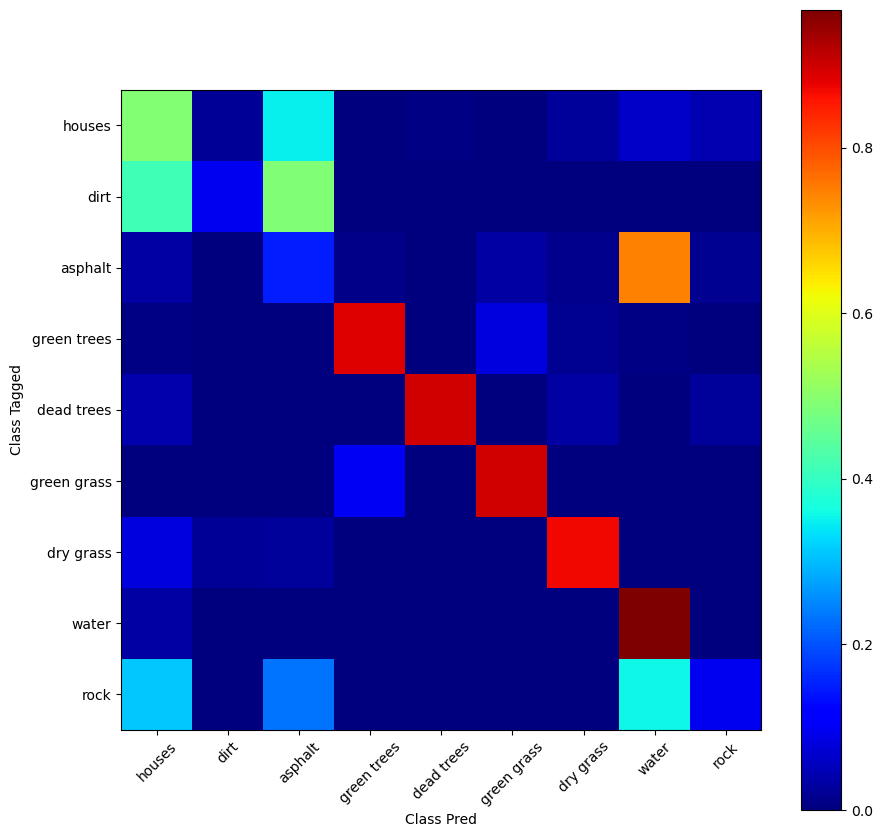

House Accuracy : 0.49435825105782794
Dirt Accuracy : 0.0952101087275933
Asphalt Accuracy : 0.14811066126855602
GreenTree Accuracy : 0.8838378197252318
DeadTree Accuracy : 0.8960798816568047
GreenGrass Accuracy : 0.8969643252825171
DryGrass Accuracy : 0.8699331383201003
Water Accuracy : 0.9666535896429973
Rock Accuracy : 0.09607186358099878
Overall Accuracy 0.7022015612665555
Unburnable Accuracy 0.9862738137498521
Mix Burnable Accuracy 0.9492556666583547
Unmixed Burnable Accuracy 0.88447248335536
Saving as tif raster file
this took  379.028137922287 seconds


In [4]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711954_sw_11_100.tif'
tagFile2='hxip_m_3711954_sw_11_100_agfeb11.tif'
outFile2="hxip_m_3711954_sw_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  17817
roads tagged  4731
asphalts tagged  2292
greentree tagged  9912
dead trees tagged  2969
green grass tagged  12868
dry grass tagged  4992
water tagged  4028
rocks tagged  13889
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


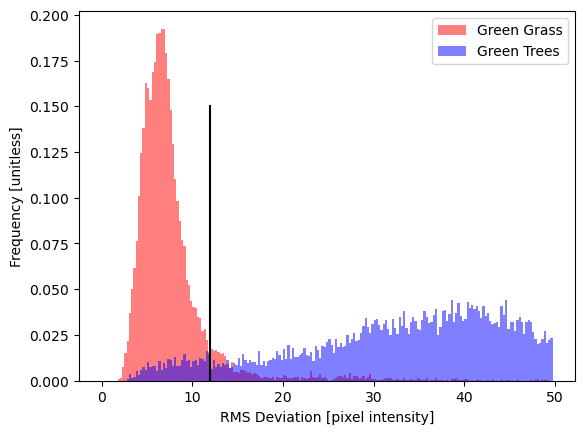

Creating the Confusion Matrix


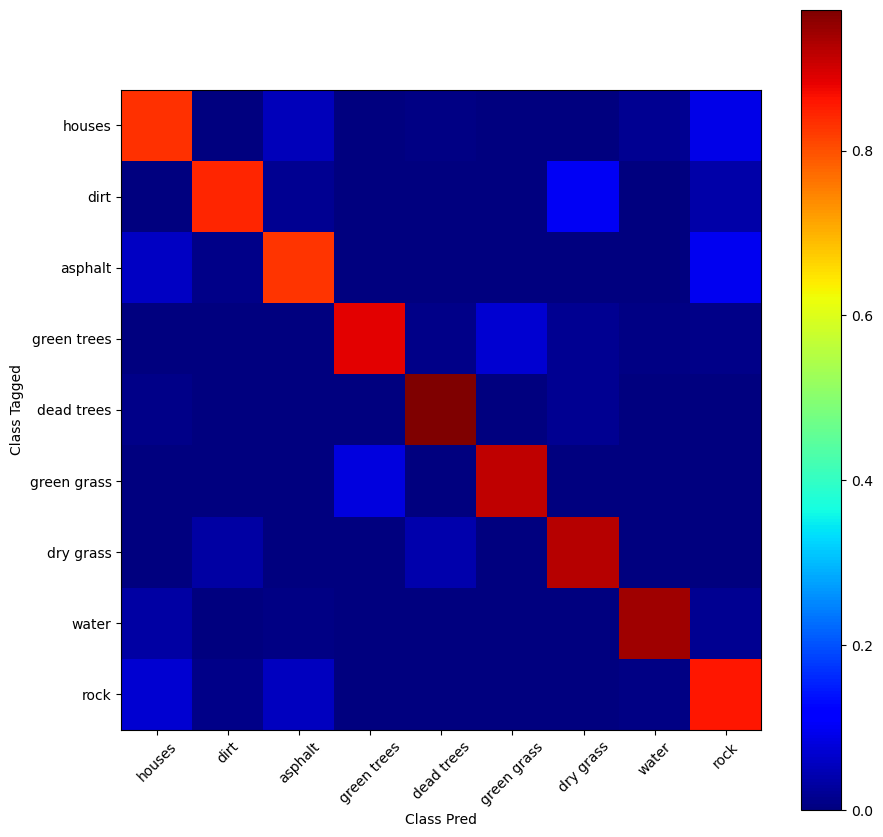

House Accuracy : 0.8306673401807263
Dirt Accuracy : 0.8452758402029169
Asphalt Accuracy : 0.8294066317626527
GreenTree Accuracy : 0.8845843422114609
DeadTree Accuracy : 0.9706972044459414
GreenGrass Accuracy : 0.9156823127137085
DryGrass Accuracy : 0.9236778846153846
Water Accuracy : 0.9438927507447865
Rock Accuracy : 0.8571531427748578
Overall Accuracy 0.876908215189529
Unburnable Accuracy 0.9830203241574479
Mix Burnable Accuracy 0.987345889853941
Unmixed Burnable Accuracy 0.9122670049770665
Saving as tif raster file
this took  435.2791202068329 seconds


In [5]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711955_nw_11_100.tif'
tagFile2='hxip_m_3711955_nw_11_100_agfeb11.tif'
outFile2="hxip_m_3711955_nw_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  6193
roads tagged  6085
asphalts tagged  6269
greentree tagged  6597
dead trees tagged  5658
green grass tagged  6357
dry grass tagged  4065
water tagged  5036
rocks tagged  7837
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


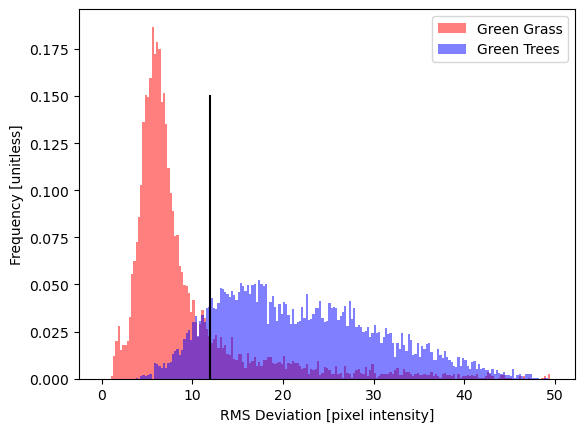

Creating the Confusion Matrix


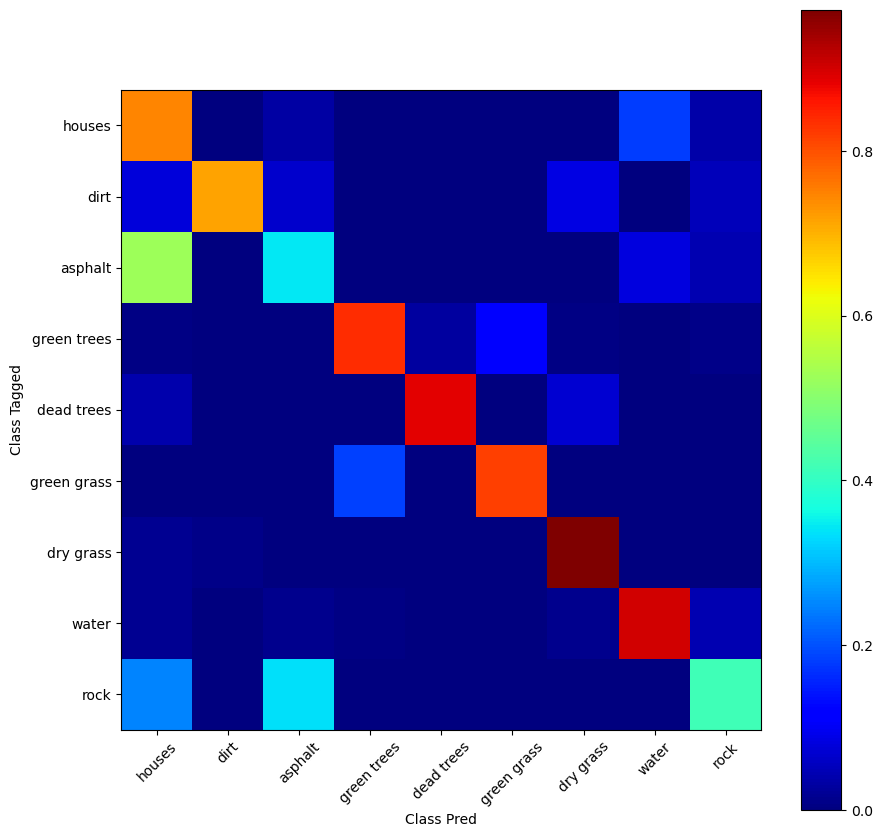

House Accuracy : 0.7440658808331988
Dirt Accuracy : 0.713886606409203
Asphalt Accuracy : 0.3432764396235444
GreenTree Accuracy : 0.8376534788540245
DeadTree Accuracy : 0.8856486390950866
GreenGrass Accuracy : 0.8164228409627182
DryGrass Accuracy : 0.9712177121771217
Water Accuracy : 0.9025019857029388
Rock Accuracy : 0.4144443026668368
Overall Accuracy 0.7130155091779581
Unburnable Accuracy 0.9779758115849777
Mix Burnable Accuracy 0.980023812673634
Unmixed Burnable Accuracy 0.8676191736120298
Saving as tif raster file
this took  424.9868142604828 seconds


In [6]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711962_nw_11_100.tif'
tagFile2='hxip_m_3711962_nw_11_100_AK_2023Oct18.tif'
outFile2="hxip_m_3711962_nw_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  2837
roads tagged  2038
asphalts tagged  2772
greentree tagged  2162
dead trees tagged  2101
green grass tagged  1398
dry grass tagged  2678
water tagged  2247
rocks tagged  2202
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


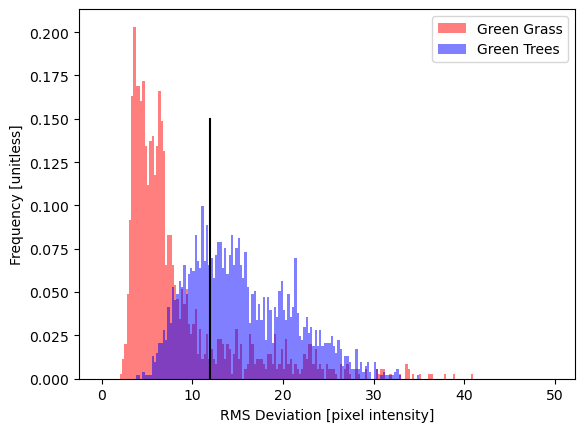

Creating the Confusion Matrix


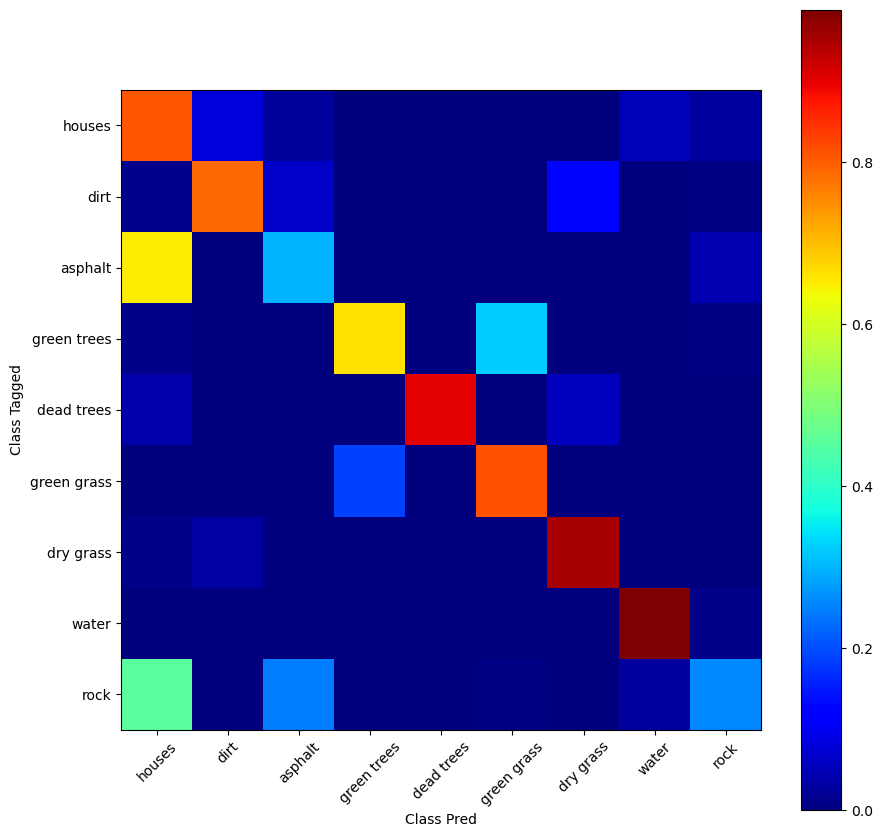

House Accuracy : 0.8093056045118082
Dirt Accuracy : 0.7885181550539745
Asphalt Accuracy : 0.30014430014430016
GreenTree Accuracy : 0.6609620721554117
DeadTree Accuracy : 0.900523560209424
GreenGrass Accuracy : 0.8111587982832618
DryGrass Accuracy : 0.9529499626587006
Water Accuracy : 0.9884290164663997
Rock Accuracy : 0.2574931880108992
Overall Accuracy 0.7110349889894788
Unburnable Accuracy 0.9753637566137566
Mix Burnable Accuracy 0.9700203861374266
Unmixed Burnable Accuracy 0.8402686173402086
Saving as tif raster file
this took  405.7803635597229 seconds


In [4]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711954_ne_11_100.tif'
tagFile2='hxip_m_3711954_ne_11_100_AK_2023Oct18.tif'
outFile2="hxip_m_3711954_ne_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  2054
roads tagged  1946
asphalts tagged  1972
greentree tagged  1968
dead trees tagged  1957
green grass tagged  2111
dry grass tagged  1992
water tagged  2162
rocks tagged  2032
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


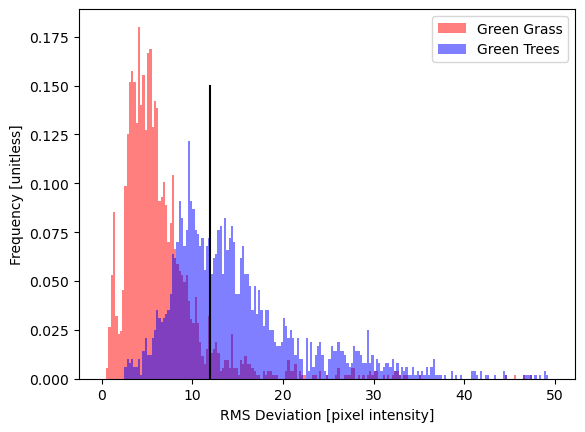

Creating the Confusion Matrix


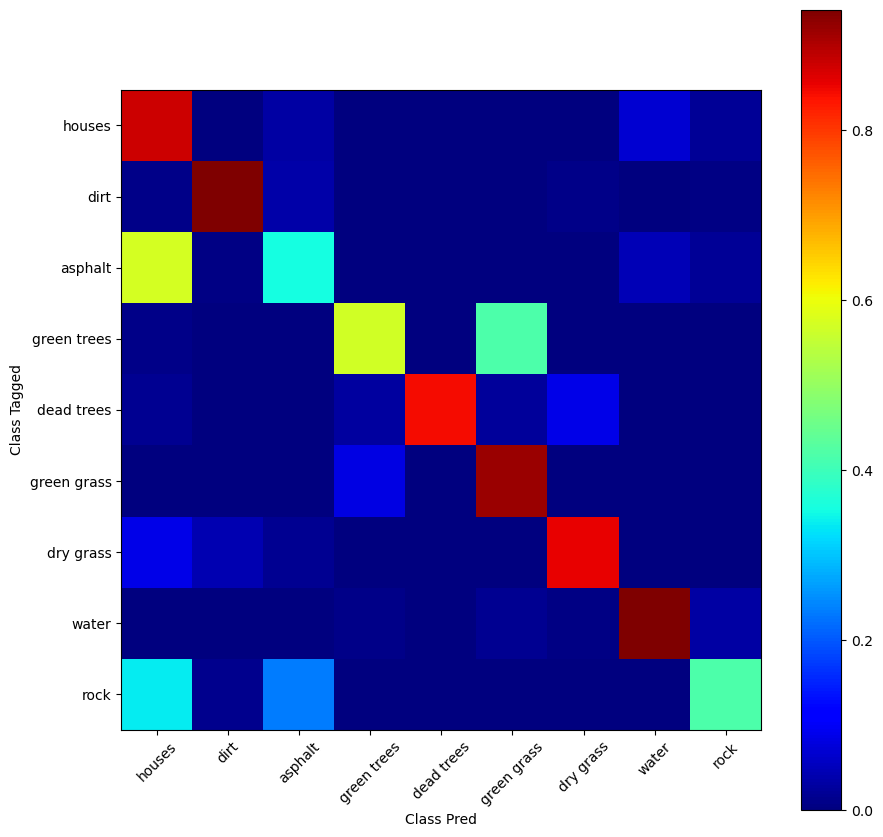

House Accuracy : 0.8768257059396299
Dirt Accuracy : 0.9414182939362795
Asphalt Accuracy : 0.3554766734279919
GreenTree Accuracy : 0.5685975609756098
DeadTree Accuracy : 0.8431272355646398
GreenGrass Accuracy : 0.9185220274751302
DryGrass Accuracy : 0.8554216867469879
Water Accuracy : 0.9398704902867715
Rock Accuracy : 0.4187992125984252
Overall Accuracy 0.749093107617896
Unburnable Accuracy 0.9916387959866221
Mix Burnable Accuracy 0.9575236671649228
Unmixed Burnable Accuracy 0.7987045341305431
Saving as tif raster file
this took  423.34760546684265 seconds


In [5]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711962_sw_11_100.tif'
tagFile2='hxip_m_3711962_sw_11_100_AK_2023Oct18.tif'
outFile2="hxip_m_3711962_sw_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')

loading the data
houses tagged  2713
roads tagged  2017
asphalts tagged  2175
greentree tagged  2351
dead trees tagged  2880
green grass tagged  2907
dry grass tagged  3274
water tagged  3119
rocks tagged  2261
Running mlp.predict
Running RMSD Analysis
Making the cut on RMSD


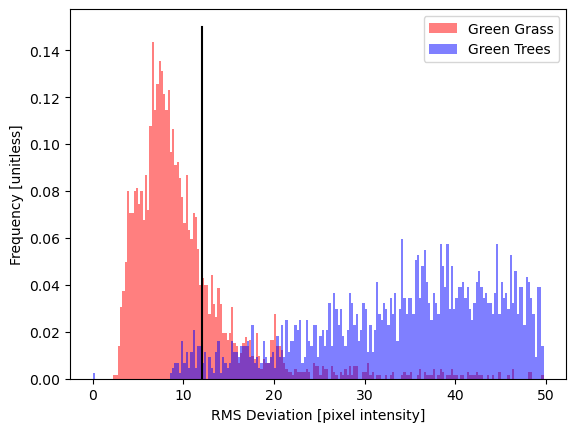

Creating the Confusion Matrix


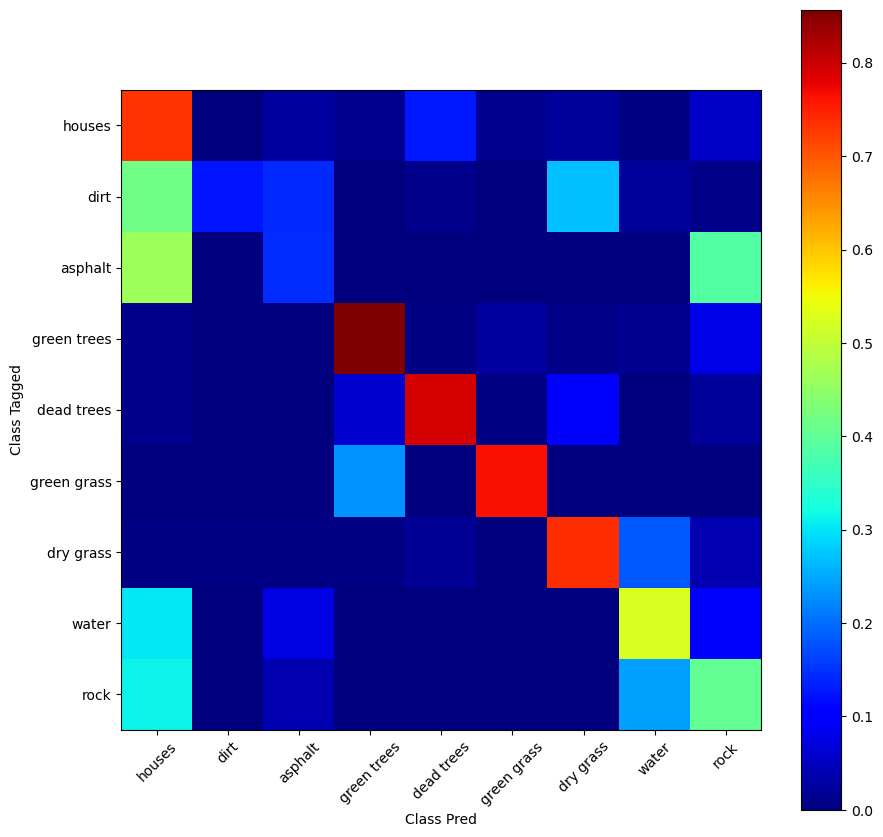

House Accuracy : 0.7305565794323627
Dirt Accuracy : 0.12592959841348536
Asphalt Accuracy : 0.14574712643678162
GreenTree Accuracy : 0.8566567418119949
DeadTree Accuracy : 0.7920138888888889
GreenGrass Accuracy : 0.7660818713450293
DryGrass Accuracy : 0.7394624312767257
Water Accuracy : 0.5232446296890029
Rock Accuracy : 0.4015922158337019
Overall Accuracy 0.5923112630290754
Unburnable Accuracy 0.9117623117623118
Mix Burnable Accuracy 0.9007185418857343
Unmixed Burnable Accuracy 0.7836487907465826
Saving as tif raster file
this took  551.5516037940979 seconds


In [6]:
################### Prediction Only Cell #########################################################
################### This block  predict the classes for the entire map (mlp.predict) (WITHOUT Training)
################### Then Run the RMSD Analysis to differentiate Green Trees vs Grass #############################
start = time.time()

#define your input and output files
imageFile2='/data/wto/AerialImages/hxip_m_3711955_ne_11_100.tif'
tagFile2='hxip_m_3711955_ne_11_100_AK_2023Oct18.tif'
outFile2="hxip_m_3711955_ne_11_100_NNRMSD.tif"


print("loading the data")
tmp, tmp, tmp, tmp, X_matrix2, X_flat2, Y_matrix2, Y_flat2  = LoadTrainingData( imageFile2,tagFile2)


print("Running mlp.predict")
Y_predict2 = mlp.predict(X_flat2)


print("Running RMSD Analysis")
Y_predict_matrix2 = np.reshape(Y_predict2, X_matrix2[0].shape)
NIR_RMS2 = RMSD_of_band5x5(X_matrix2[3], Y_predict_matrix2)

NIR_RMS_f2 = NIR_RMS2.flatten()

#print("Making the cut on RMSD")
#for i in range(len(NIR_RMS_f2)):
#    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
#        Y_predict2[i]=6

print("Making the cut on RMSD")
NIR_RMS2_4 = []
NIR_RMS2_6 = []
for i in range(len(NIR_RMS_f2)):
    if(Y_flat2[i] == 4): NIR_RMS2_4.append(NIR_RMS_f2[i])
    if(Y_flat2[i] == 6): NIR_RMS2_6.append(NIR_RMS_f2[i])  
    if ( NIR_RMS_f2[i]<RMSD_CUT and Y_predict2[i]==4 ):
        Y_predict2[i]=6

rmsd_bins= np.arange(0,50,0.25)
plt.hist(NIR_RMS2_6, rmsd_bins, alpha=0.5, label='Green Grass', color='r', density = True)
plt.xlabel("RMS Deviation [pixel intensity]")
plt.ylabel("Frequency [unitless]")
plt.hist(NIR_RMS2_4, rmsd_bins, alpha=0.5, label='Green Trees', color='b',density = True)
plt.plot([RMSD_CUT,RMSD_CUT],[0,0.15], color='k')
plt.legend(loc='upper right')
plt.show()  
        
############ Confusion Matrix Test###########
print("Creating the Confusion Matrix")
cm = metrics.confusion_matrix(Y_flat2[Y_flat2!=0],Y_predict2[Y_flat2!=0])

cm_norm = []
for i in range(len(cm)):
    row = cm[i]/np.sum(cm[i])
    cm_norm.append(row)
cm_norm= np.array(cm_norm)    

fulltargets =['houses', 'dirt', 'asphalt', 'green trees', 'dead trees', 'green grass','dry grass', 'water','rock']

fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.imshow(cm_norm,cmap='jet',extent=[0.5,9.5,0.5,9.5])
plt.colorbar()

plt.xlabel("Class Pred")
ax.set_xticks([1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(fulltargets)
plt.xticks(rotation = 45)
plt.ylabel("Class Tagged")
ax.set_yticks([1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(fulltargets[::-1])
plt.show()
############ End Confusion Matrix Test###########

PrintAcc(Y_predict2,Y_flat2)
SavePredictTif(Y_predict2,imageFile2,outFile2)
print('this took ', time.time()-start, 'seconds')